## Pedestrian Detection

In [2]:
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.applications import MobileNetV2, VGG16
from keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Flatten, Activation, Reshape, Input, LeakyReLU
from keras.models import Model, Sequential, load_model, save_model, model_from_json
from keras.optimizers import Adam, RMSprop, SGD
from keras.initializers import glorot_uniform
from keras import backend as K
from decode_boxes import *
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg

Using TensorFlow backend.


## Loading Data

In [3]:
X_train = np.load('Data/X_train.npy')
Y_train = np.load('Data/Y_train.npy')
X_val = np.load('Data/X_val.npy')
Y_val = np.load('Data/Y_val.npy')

In [4]:
X_train.shape

(706, 512, 512, 3)

In [5]:
Y_train.shape

(706, 16, 16, 1, 5)

In [6]:
X_val.shape

(578, 512, 512, 3)

In [8]:
img_width = 512
img_height = 512
grid_size = 16

## Loss function for yolo algorithm

In [9]:
def loss_func(y_true,y_pred):

    lambda_coords = 5.0
    lambda_noob = 0.5
    
    p_true = y_true[:,:,:,:,0]
    p_pred = y_pred[:,:,:,:,0]
    
    obj = y_true[:,:,:,:,0]
    noobj = -1 * (obj - 1)
    
    center_x_true = y_true[:,:,:,:,1]
    center_x_pred = y_pred[:,:,:,:,1]
    
    center_y_true = y_true[:,:,:,:,2]
    center_y_pred = y_pred[:,:,:,:,2]
    
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]
    
    p_loss = (K.sum(obj * K.square(p_pred - p_true))) + (lambda_noob * K.sum(noobj * K.square(p_pred - p_true)))
    
    center_loss = lambda_coords * K.sum(obj * (K.square(center_x_pred - center_x_true) + K.square(center_y_pred - center_y_true)))
    
    wh_loss = lambda_coords * K.sum(obj * (K.square(K.sqrt(w_pred) - K.sqrt(w_true)) + K.square(K.sqrt(h_pred) - K.sqrt(h_true))))
    
    loss = p_loss + center_loss + wh_loss
    
    return loss

## Loading VGG16 Weights

In [12]:
vgg = VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top = False, input_shape = (512,512,3))

## Pedestrian Detection Model

In [13]:
def pedestrain_model():
    
    model_input = vgg.input
    layer = vgg.output
    
    X = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(layer)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(0.4)(X)
    
    
    X = Conv2D(filters = 5, kernel_size = (3, 3), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    
    model_output = Reshape((grid_size, grid_size, 1, 5))(X)
    
    model = Model(model_input,model_output)
    
    
    return model

In [14]:
model = pedestrain_model()
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
___________________________

In [15]:
adam = Adam(lr=0.0001)
model.compile(loss=loss_func, optimizer=adam, metrics=['accuracy'])

In [16]:
model.fit(X, Y, epochs= 10 ,batch_size = 16)

In [17]:
model.save('pedestrian_model.h5')

## Save model in json file

In [18]:
json_string = model.to_json()
json_file = open('pedestrian_model.json', 'w')
json_file.write(json_string)
json_file.close()

## load model andpretrained weights

In [19]:
json_file = open('pedestrian_model.json', 'r')

model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)

model.load_weights('pedestrian_model.h5')

## Predict 

In [20]:
def predict(input_img, model, iou_value):
    
    img = cv2.resize(input_img, (512,512))
    img = (img-127.5) / 127.5
    img = img.reshape((1,512,512,3))
    
    output = model.predict(img)
    
    img = (img +1)/2
    img = img[0]
    
    boxes = get_boxes(output[0],iou_value,input_img.shape[1],input_img.shape[0])

    for box in boxes:
        input_img = cv2.rectangle(input_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color=(255,255,0), thickness = 2)
    
    return input_img

## Prediction on Some Images

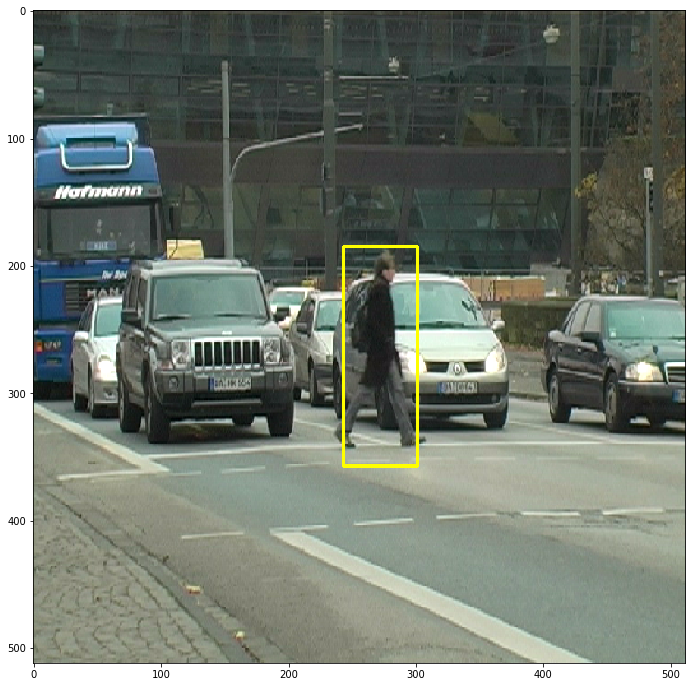

In [21]:
img = predict(X_val[369], model, 0.2)
plt.figure(figsize = (12, 12))
plt.imshow(img)

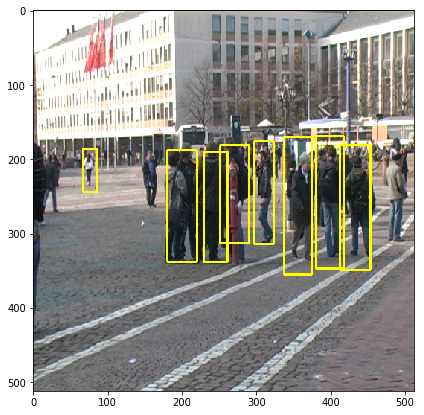

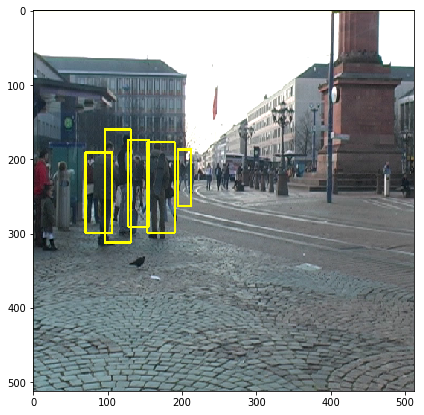

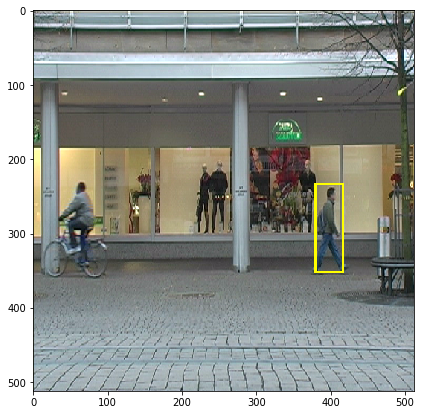

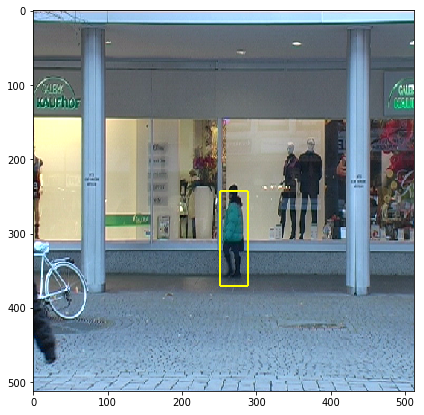

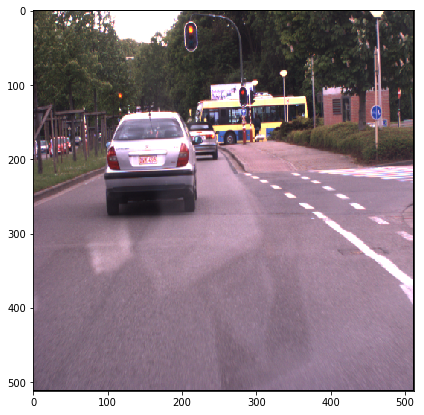

In [28]:
select = np.random.randint(0, X_val.shape[0], 5)

for i in select:
    img = predict(X_val[i], model, 0.2)
    plt.figure(figsize = (7, 7))
    plt.imshow(img)